# Prueba Data Science


### Datos
DATA DESCRIPTION:

•	policy_desc: Policy Identifier; Primary Key which is unique for every policy

•	claim_count: Total Claims (This is the response you should predicting); Numeric Variable

•	cat_areacode: Area Code; Categorical Variable

•	num_vehicleAge: Age of the vehicle; Numeric Variable

•	num_noClaimDiscountPercent: Percentage of discount applied to policy premium based on claim history. If value is greater than 100 then policy premium was increased, if it’s less than 100 a discount was applied. A value of 100 means the premium remain unchanged; Numerical Variable

•	cat_carBrand: Insured Vehicle Brand; Categorical Variable

•	num_populationDensitykmsq: Population density of the city the policy holder lives in; Numerical Variable

•	cat_Region; Region of the country the policy holder lives in; Categorical Variable

•	ord_vehicleHP: Vehicle Horsepower; This feature is anonymised but maintains the same ordinality; Ordinal Variable

•	num_exposure: Exposure time of policy. Time period within which the claims were made; Numerical Variable

•	cat_fuelType: Insured Vehicle Fuel Type; Categorical Variable

•	num_driverAge: Age of the Policy Holder; Numerical Variable




Primero importo librerias utiles aunque no las use todas

In [227]:

#Python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

#Regressor Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

#Classifier Models
from sklearn.ensemble import RandomForestClassifier


# data processing
from sklearn import metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


# transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# sklearn
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, power_transform, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingRegressor

#Otros
import optuna
import pickle

# typing
from typing import List, Dict, Tuple, Union, Generator, Optional, Any






Este codigo es util para poder realizar revision de resultados de lo que vaya haciendo 

In [195]:
# utils
def performance_regression_model(
        y_true: np.array, 
        y_pred: np.array,
        view_plot: bool=True,
        view_stats: bool=True
    )->Dict:
    """"""

    model_score: Dict = dict(
        r2=r2_score(y_true, y_pred),
        rmse=mean_squared_error(y_true, y_pred, squared=False),
        mse=mean_squared_error(y_true, y_pred),
        mae=mean_absolute_error(y_true, y_pred)
    )

    if view_plot:
        pd.DataFrame({
            'predictions':y_pred,
            'residuals':y_true - y_pred         
        }).plot(
            x='predictions', y='residuals', kind='scatter',
            c='black', s=10, alpha=0.1
        )

    if view_stats:
        print('r2:', model_score.get('r2'))
        print('RMSE:', model_score.get('rmse'))
        print('mse:', model_score.get('mse'))
        print('mae:', model_score.get('mse'))
    
    return model_score

In [176]:
dataTraining = pd.read_csv('casestudy_data.csv')

C:\Users\WD\AppData\Local\Temp\ipykernel_16360\1013168171.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataTraining = pd.read_csv('casestudy_data.csv')


Revision de datos inicial

In [177]:
dataTraining.head()

,policy_desc,claim_count,cat_areacode,num_vehicleAge,num_noClaimDiscountPercent,cat_carBrand,num_populationDensitykmsq,cat_Region,ord_vehicleHP,num_exposure,cat_fuelType,num_driverAge
0,1,1,D,0,50,B12,1217,R82,5,0.1,Regular,55
1,3,1,D,0,50,B12,1217,R82,5,0.77,Regular,55
2,5,1,B,2,50,B12,54,R22,6,0.75,Diesel,52
3,10,1,B,0,50,B12,76,R72,7,0.09,Diesel,46
4,11,1,B,0,50,B12,76,R72,7,0.84,Diesel,46


Elimino Policy_Desc porque no hay ningun valor repetido y todas son polizas unicas en los datos

In [178]:
dataTraining.drop(['policy_desc'],axis=1,inplace=True)

In [179]:
dataTraining['claim_count'].value_counts()

claim_count
0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
9          1
Name: count, dtype: int64

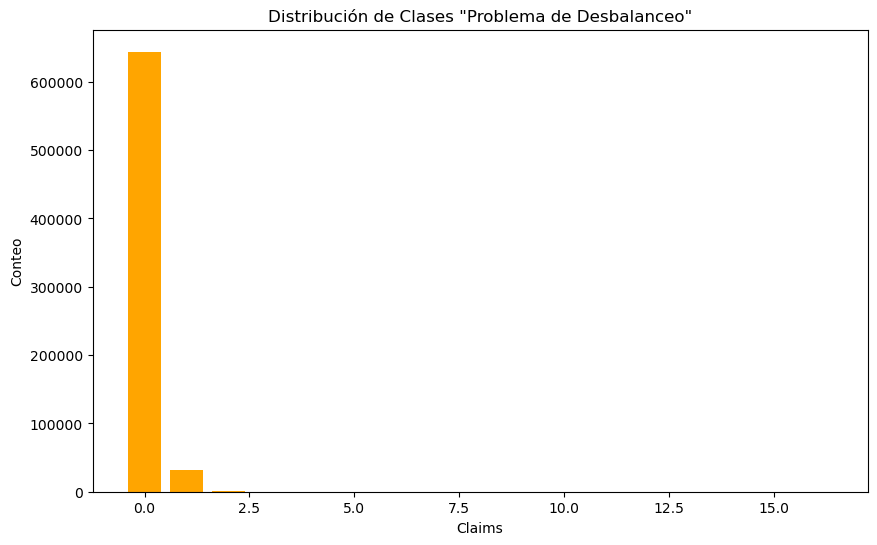

In [216]:
conteo = {
    0: 643919,
    1: 32176,
    2: 1784,
    3: 82,
    4: 7,
    11: 3,
    5: 2,
    6: 1,
    8: 1,
    16: 1,
    9: 1
}

clases = list(conteo.keys())
frecuencias = list(conteo.values())

plt.figure(figsize=(10, 6))
plt.bar(clases, frecuencias, color='orange')

plt.xlabel('Claims')
plt.ylabel('Conteo')
plt.title('Distribución de Clases "Problema de Desbalanceo"')

plt.show()

#### Eliminacion valores vacios (asi venian inicialmente)

cat_fuelType                  22


num_driverAge                 14

In [180]:
dataTraining.dropna(inplace=True)
dataTraining.isnull().sum()

claim_count                   0
cat_areacode                  0
num_vehicleAge                0
num_noClaimDiscountPercent    0
cat_carBrand                  0
num_populationDensitykmsq     0
cat_Region                    0
ord_vehicleHP                 0
num_exposure                  0
cat_fuelType                  0
num_driverAge                 0
dtype: int64

En los datos se puede ver que toma num_exposure y num_driverAge como objects pero son float e int, la razon es valores raros como 10years, 23years, etc. 
En este caso solo se convertira en numeric y cualquier otro valor convertira en NaN

In [181]:
dataTraining.dtypes

claim_count                    int64
cat_areacode                  object
num_vehicleAge                 int64
num_noClaimDiscountPercent     int64
cat_carBrand                  object
num_populationDensitykmsq      int64
cat_Region                    object
ord_vehicleHP                  int64
num_exposure                  object
cat_fuelType                  object
num_driverAge                 object
dtype: object

In [218]:
#print(dataTraining['num_exposure'].unique())
#print(dataTraining['num_driverAge'].unique())
dataTraining['num_exposure'] = pd.to_numeric(dataTraining['num_exposure'], errors='coerce')

dataTraining['num_driverAge'] = pd.to_numeric(dataTraining['num_driverAge'], errors='coerce')
dataTraining.dtypes

claim_count                     int64
cat_areacode                   object
num_vehicleAge                  int64
num_noClaimDiscountPercent      int64
cat_carBrand                   object
num_populationDensitykmsq       int64
cat_Region                     object
ord_vehicleHP                   int64
num_exposure                  float64
cat_fuelType                   object
num_driverAge                 float64
dtype: object

# Regresion

## Definicion Pipeline datos

Se define un pipeline para la transformacion de variables numericas y categoricas. Para las numericas se utiliza StandardScaler y para las categoricas se utiliza One-Hot Encoder

In [240]:
# Identificación de columnas
num_cols = [col for col in dataTraining.select_dtypes(include='int64').columns if col != 'claim_count']
cat_cols = dataTraining.select_dtypes(include='object').columns.tolist()
target_col = 'claim_count' if 'claim_count' in dataTraining.columns else None

# Separación de datos en X e y
X = pd.concat([dataTraining[num_cols], dataTraining[cat_cols].astype('category')], axis=1)
y = dataTraining[target_col].astype('category')

# preprocesamiento
numeric_pipe = make_pipeline(StandardScaler(),PowerTransformer())
categorical_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocessor = make_column_transformer(
    (numeric_pipe, num_cols),
    (categorical_pipe, cat_cols)
)

# canalizacion
transformation_pipe = make_pipeline(preprocessor)
transformation_pipe.fit(X)

X_transformed = transformation_pipe.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.33, random_state=0)

Pipeline de preprocesamiento definido, se separa en solo los datos transformados para mayor rapidez en la optimizacion de hiperparametros

In [221]:
transformation_pipe 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['num_vehicleAge',
                                                   'num_noClaimDiscountPercent',
                                                   'num_populationDensitykmsq',
                                                   'ord_vehicleHP']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cat_areacode',
                                                   'cat_carBrand', 'cat_Region',
                                                   'cat_fuelType'])]))])

## Modelos

### XGBoost

Como se puede ver solo un modelo no es muy util pues presenta r2 de 0.25, es decir que solo se explica el 25% de la variable objetivo con el actual modelo

r2: 0.02243327024950792
RMSE: 0.23827422848369573
mse: 0.05677460795950044
mae: 0.05677460795950044


c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'r2': 0.02243327024950792,
 'rmse': 0.23827422848369573,
 'mse': 0.05677460795950044,
 'mae': 0.0982606313732968}

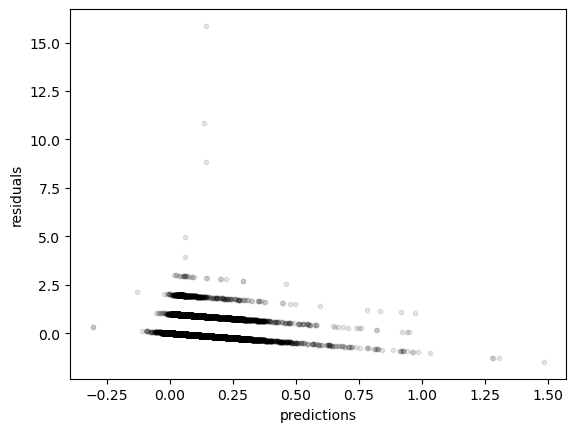

In [224]:
XGBRegPipe = XGBRegressor()
XGBRegPipe.fit(X_train, y_train)

ypred=XGBRegPipe.predict(X_test)
RMSENotScaledSVM=mean_squared_error(y_test, ypred)


performance_regression_model(y_test.to_numpy().ravel(), ypred)

Optimizacion de hiperparametros modelo XGBoost

In [79]:
def objective(trial):
    # Definición de los hiperparámetros a optimizar
    param = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0)
    }
    

    model = XGBRegressor(**param, enable_categorical=True)

    # Entrenamiento del modelo
    model.fit(X_train_transformed, y_train)

    # Realización de predicciones en el conjunto de prueba
    y_pred = model.predict(X_test_transformed)

    # Cálculo de la métrica de evaluación (error cuadrático medio)
    mse = mean_squared_error(y_test, y_pred)

    return mse

In [80]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-08-01 09:23:37,364] A new study created in memory with name: no-name-4da1965f-03a8-4ce5-bba3-fc28f31117b6
[I 2024-08-01 09:23:38,485] Trial 0 finished with value: 0.04371361504908737 and parameters: {'max_depth': 9, 'learning_rate': 0.2144146646561897, 'n_estimators': 121, 'subsample': 0.9846128479067022, 'colsample_bytree': 0.922409115452502, 'min_child_weight': 6, 'gamma': 0.8507544127120458}. Best is trial 0 with value: 0.04371361504908737.
[I 2024-08-01 09:23:40,578] Trial 1 finished with value: 0.04369415001672142 and parameters: {'max_depth': 10, 'learning_rate': 0.10325173659915517, 'n_estimators': 265, 'subsample': 0.8078320116675579, 'colsample_bytree': 0.84180857028226, 'min_child_weight': 6, 'gamma': 0.6209571198621009}. Best is trial 1 with value: 0.04369415001672142.
[I 2024-08-01 09:23:42,450] Trial 2 finished with value: 0.04386465403009727 and parameters: {'max_depth': 8, 'learning_rate': 0.2516656898641312, 'n_estimators': 275, 'subsample': 0.5621481468194218, 

In [81]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 10, 'learning_rate': 0.02526721602824744, 'n_estimators': 220, 'subsample': 0.9027010910475677, 'colsample_bytree': 0.6340801908849835, 'min_child_weight': 3, 'gamma': 0.07750413308001167}


In [171]:
paramsxg1 = {
    'objective': 'reg:squarederror',  # Objetivo de regresión con error cuadrado
    'max_depth': 10,                   # Profundidad máxima de los árboles
    'learning_rate': 0.02405465164605032,             # Tasa de aprendizaje
    'n_estimators': 180,              # Número de árboles a construir
    'subsample':  0.5628425093858869,                 # Submuestra de datos para el entrenamiento de cada árbol
    'colsample_bytree': 0.9771032389526358,          # Submuestra de características para el entrenamiento de cada árbol
    'min_child_weight': 9,
    'gamma':0.09999149057168405
}

No hay una mejora muy significativa:

R2 de 0.25 a 0.29.

RMSE de 0.208 a 0.237

MSE de 0.0435 a 0.0563

MAE de 0.0981 a 0.0981 NO CAMBIO


r2: 0.029009188268484865
RMSE: 0.23747146195020608
mse: 0.05639269524076817
mae: 0.05639269524076817


c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'r2': 0.029009188268484865,
 'rmse': 0.23747146195020608,
 'mse': 0.05639269524076817,
 'mae': 0.09811019207171173}

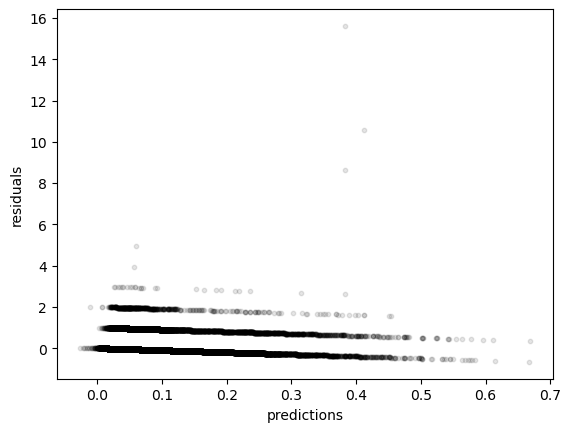

In [197]:
XGBReg1_Optuna = XGBRegressor(enable_categorical=True,**paramsxg1)

XGBReg1_Optuna.fit(X_train,y_train)

y_pred = XGBReg1_Optuna.predict(X_test)
performance_regression_model(y_test.to_numpy().ravel(), y_pred)

### Random Forest

In [192]:
# crear el modelo Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=0, n_jobs=-1)

#  entrenamiento
rf_regressor.fit(X_train, y_train)

# hacer predicciones con los datos de prueba
y_pred_rf = rf_regressor.predict(X_test)


c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


NameError: name 'sqrt' is not defined

r2: -0.13263177849834307
RMSE: 0.2564768889293617
mse: 0.06578039455488416
mae: 0.06578039455488416


c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'r2': -0.13263177849834307,
 'rmse': 0.2564768889293617,
 'mse': 0.06578039455488416,
 'mae': 0.1000491992050872}

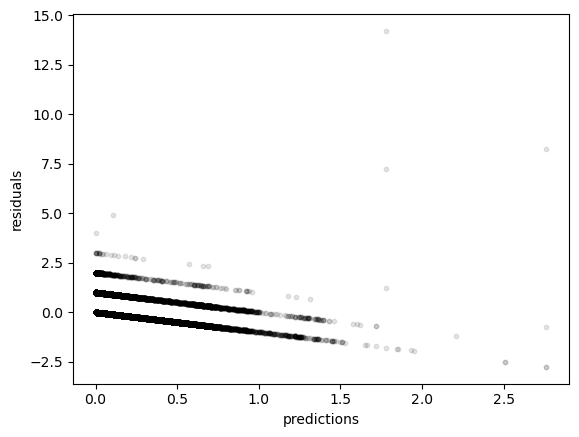

In [198]:
performance_regression_model(y_test.to_numpy().ravel(), y_pred_rf)

### Light GBM

In [201]:

def para(trial):
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    param = {
        'boosting_type': boosting_type,
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),

    }

    if boosting_type != 'goss':
        param['feature_fraction'] = trial.suggest_float('feature_fraction', 0.4, 1.0),
        param['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.4, 1.0),
        param['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 7)

    modelo = lgb.LGBMRegressor(**param, early_stopping_rounds=50, verbose=-1)
    modelo.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    preds = modelo.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

revision= optuna.create_study(direction='minimize')
revision.optimize(para, n_trials=100)

print('Number of finished trials:', len(revision.trials))
print('Best trial:', revision.best_trial.params)

[I 2024-08-01 11:06:17,816] A new study created in memory with name: no-name-e4ad3a74-a4c7-40ed-a707-395a9543a48b
C:\Users\WD\AppData\Local\Temp\ipykernel_16360\2588194839.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10),
c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn

Number of finished trials: 100
Best trial: {'boosting_type': 'gbdt', 'max_depth': 9, 'min_child_weight': 0.39741280978963384, 'num_leaves': 157, 'n_estimators': 283, 'reg_alpha': 0.6423090192749432, 'learning_rate': 0.10258568910633607, 'feature_fraction': 0.933464561635812, 'bagging_fraction': 0.8411845000613677, 'bagging_freq': 2}


In [ ]:
#Best trial: {'boosting_type': 'gbdt', 'max_depth': 9, 'min_child_weight': 0.39741280978963384, 'num_leaves': 157, 'n_estimators': 283, 'reg_alpha': 0.6423090192749432, 'learning_rate': 0.10258568910633607, 'feature_fraction': 0.933464561635812, 'bagging_fraction': 0.8411845000613677, 'bagging_freq': 2}

In [202]:

# Inicializar el estimador con LightGBM
estima = lgb.LGBMRegressor()

# Preparar el conjunto de datos en el formato de LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Configurar los parámetros del modelo
paramsLG = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 9,
    'min_child_weight': 0.39741280978963384,
    'num_leaves': 157,
    'n_estimators': 283,
    'reg_alpha':0.6423090192749432,

    'learning_rate': 0.10258568910633607,
    'feature_fraction': 0.933464561635812,
    'bagging_fraction': 0.8411845000613677,
    'bagging_freq': 2,
    'verbose': -1
}

# Entrenar el modelo
gbm = lgb.train(paramsLG,
                train_data,
                num_boost_round=10000,
                valid_sets=valid_data)

# Predecir
y_pred_LGBM = gbm.predict(X_test, num_iteration=gbm.best_iteration)


c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


r2: 0.02826561154120477
RMSE: 0.23756237138918482
mse: 0.05643588030005298
mae: 0.05643588030005298


c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'r2': 0.02826561154120477,
 'rmse': 0.23756237138918482,
 'mse': 0.05643588030005298,
 'mae': 0.09806673003510805}

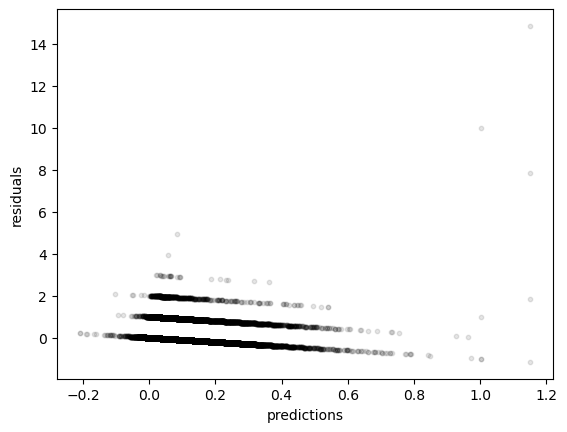

In [209]:
performance_regression_model(y_test.to_numpy().ravel(), y_pred_LGBM)

### Stacking

In [229]:
estimators = [
    ('lgbm', lgb.LGBMRegressor(
        boosting_type='gbdt',
        objective='regression',
        metric='rmse',
        max_depth=9,
        min_child_weight=0.39741280978963384,
        num_leaves=157,
        n_estimators=283,
        reg_alpha=0.6423090192749432,
        learning_rate=0.10258568910633607,
        feature_fraction=0.933464561635812,
        bagging_fraction= 0.8411845000613677,
        bagging_freq=2,
        verbose=-1,
        n_jobs=-1
    )),
    ('xgb', XGBRegressor(
        n_estimators=180,
        max_depth=10,
        learning_rate=0.02405465164605032,
        subsample=0.5628425093858869,
        colsample_bytree=0.9771032389526358,
        min_child_weight=9,
        gamma=0.09999149057168405,
        random_state=42,
        n_jobs=-1
    )),
     ('rf', RandomForestRegressor(
         random_state=42,
         n_jobs=-1
    ))

]



# definir el meta-modelo
final_estimator = LinearRegression()

# crear el modelo de stacking
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5
)

# entrenar el modelo de stacking
stacking_model.fit(X_train, y_train)

# Hacer predicciones con el modelo de stacking
y_pred_stack = stacking_model.predict(X_test)


c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\ensemble\_stacking.py:961: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [ ]:
performance_regression_model(y_test.to_numpy().ravel(), y_pred_stack)

# Clasificacion

Con clasificacion un hay errores excepto en 0 claims debido a desbalanceo de clases

In [204]:
# Identificación de columnas
num_cols = [col for col in dataTraining.select_dtypes(include='int64').columns if col != 'claim_count']
cat_cols = dataTraining.select_dtypes(include='object').columns.tolist()
target_col = 'claim_count' if 'claim_count' in dataTraining.columns else None

# Separación de datos en X e y
X = pd.concat([dataTraining[num_cols], dataTraining[cat_cols].astype('category')], axis=1)
y = dataTraining[target_col].astype('category')

# Preprocesamiento
numeric_pipe = make_pipeline(StandardScaler())
categorical_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols)
    ]
)

# Pipeline completo con modelo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=0))
])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Entrenamiento y evaluación
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    212576
           1       0.25      0.09      0.13     10539
           2       0.02      0.01      0.01       587
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1

    accuracy                           0.94    223733
   macro avg       0.14      0.12      0.12    223733
weighted avg       0.92      0.94      0.93    223733



c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\WD\.conda\envs\VSCEnv\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class=1, n=32176 (4.746%)
Class=2, n=1784 (0.263%)
Class=4, n=7 (0.001%)
Class=3, n=82 (0.012%)
Class=9, n=3 (0.000%)
Class=0, n=643919 (94.977%)
Class=5, n=2 (0.000%)
Class=6, n=1 (0.000%)
Class=7, n=1 (0.000%)
Class=10, n=1 (0.000%)
Class=8, n=1 (0.000%)


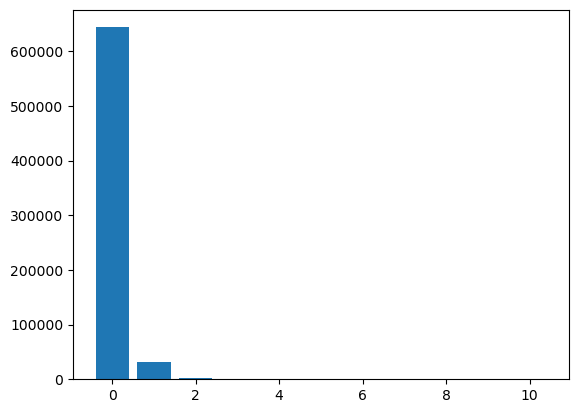

In [237]:
from collections import Counter
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Class=1, n=643919 (9.091%)
Class=2, n=643919 (9.091%)
Class=4, n=643919 (9.091%)
Class=3, n=643919 (9.091%)
Class=9, n=643919 (9.091%)
Class=0, n=643919 (9.091%)
Class=5, n=643919 (9.091%)
Class=6, n=643919 (9.091%)
Class=7, n=643919 (9.091%)
Class=10, n=643919 (9.091%)
Class=8, n=643919 (9.091%)


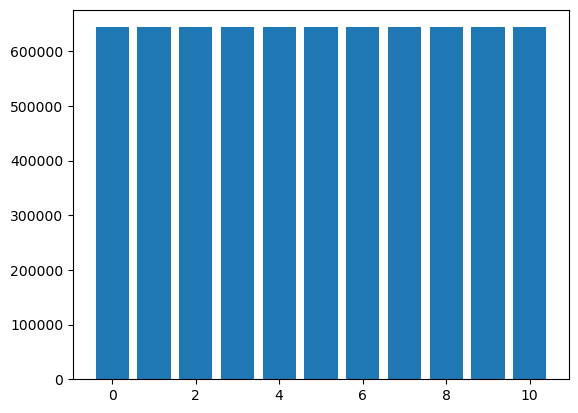

In [244]:
from imblearn.over_sampling import RandomOverSampler
# Suponiendo que y es tu variable de etiquetas y X_transformed es tu conjunto de características
y = LabelEncoder().fit_transform(y)

# Crear el sobremuestreador
oversample = RandomOverSampler()

# Aplicar el sobremuestreo
X_resampled, y_resampled = oversample.fit_resample(X_transformed, y)

# Resumen de la distribución de clases
counter = Counter(y_resampled)
for k, v in counter.items():
    per = v / len(y_resampled) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Graficar la distribución
plt.bar(counter.keys(), counter.values())
plt.show()

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)



In [248]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd


# Identificación de columnas
num_cols = [col for col in dataTraining.select_dtypes(include='int64').columns if col != 'claim_count']
cat_cols = dataTraining.select_dtypes(include='object').columns.tolist()
target_col = 'claim_count' if 'claim_count' in dataTraining.columns else None

# Separación de datos en X & y
X = pd.concat([dataTraining[num_cols], dataTraining[cat_cols].astype('category')], axis=1)
y = dataTraining[target_col]

# Preprocesamiento
numeric_pipe = make_pipeline(StandardScaler())
categorical_pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols)
    ]
)

# Verificar la distribución de clases
print(y.value_counts())

# Crear el pipeline con SMOTE
# Reducir k_neighbors si es necesario
smote = SMOTE(sampling_strategy='auto', k_neighbors=2, random_state=0)  # Ajusta k_neighbors a 2
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced'))
])

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Entrenamiento y evaluación
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

claim_count
0     643919
1      32176
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
9          1
Name: count, dtype: int64


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 3, n_samples_fit = 1, n_samples = 1